<a href="https://colab.research.google.com/github/vasilyryabtsev/ml-hse-24-25/blob/main/HW5_Boosting/AI_HW5_boosting_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашняя работа: прогнозирование заработной платы и кластеризация типов движений**

### **Постановка задачи:**

В этой работе две части:

*   В первой части вам предстоит построить алгоритм на основе бустинга для прогнозирования зарплаты
*   Во второй части вам предстоит кластеризовать типы движений по имеющимся данным с акселерометров и гироскопов

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 1 бонусный балл.

Оценка за ДЗ = min{ваш балл, 10}

**Мягкий дедлайн: 16 февраля 23:59**

**Интересной вам работы!**


# **Часть 1. Прогнозирование заработной платы при помощи бустинга**

**Количество баллов:** 7

## **Постановка задачи:**

Данные выгружены и лежат в файле `ds_salary.csv`. Вам доступны описания признаков и значения целевой переменной.

**Ваша задача:** построение модели бустинга и оценка данной модели.

## **Описание даных**

- work_year: год, в который взяты данные;
- experience_level: уровень опыта, кодируемый как SE, MI EN или EX
- employment_type: тип занятости (FT, PT, CT, FL)
- job_title: название рабочей позиции в компании;
- salary: зараплата на позиции;
- salary_currency: валюта в которой начисляют зарплату;
- employee_residence: страна или регион проживания сотрудника
- remote_ratio: процент удаленки, предлагаемый в компании (0, 50, 100)
- company_location: местоположение компании
- company_size: размер компании, оцененный как S, M, L
- salary_in_usd: целевая переменная


Как всегда, загрузим набор данных.

In [5]:
!pip install catboost
!pip install optuna
!pip install optuna-integration[catboost]

In [172]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_absolute_percentage_error as MAPE,
                             root_mean_squared_error as RMSE,
                             homogeneity_score,
                             completeness_score,
                             v_measure_score)
from sklearn.preprocessing import (OneHotEncoder,
                                   LabelEncoder,
                                   TargetEncoder,
                                   FunctionTransformer,
                                   StandardScaler)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import optuna
from optuna.integration import CatBoostPruningCallback
import warnings

warnings.filterwarnings('ignore')

In [7]:
df = pd.read_csv("https://github.com/hse-ds/iad-intro-ds/raw/refs/heads/master/2023/homeworks/hw-08-boosting/ds_salaries.csv")

In [8]:
df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M
...,...,...,...,...,...,...,...,...,...,...,...
3750,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
3751,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
3752,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
3753,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


## **Задание 1 (0.3 балла)**

Вам даны описания переменных. Проверьте, что категориальные признаки, категории которых перечислены, не имеют ошибочных значений. Для этого:

- Напишите цикл, пробегающий по выбранным признакам и оценивающий, что в них нет лишних значений;

In [9]:
experience_level_cat = ['SE', 'MI', 'EN', 'EX']
employment_type_cat = ['FT', 'PT', 'CT', 'FL']
company_size_cat = ['S', 'M', 'L']

cat_dict = {
    'experience_level': experience_level_cat,
    'employment_type': employment_type_cat,
    'company_size': company_size_cat
}

for cat in cat_dict:
    print(cat)
    print(df[df[cat].isin(cat_dict[cat])].shape[0] == df.shape[0])
    print('---------------')


experience_level
True
---------------
employment_type
True
---------------
company_size
True
---------------


`В выбранных признаках нет лишних значений.`

## **Задание 2 (0.3 балла)**

Проведите базовые шаги оценки качества данных.
- Есть есть проблемы, устраните их;
- Если нет проблем, кратко опишите это.

In [10]:
df.isna().sum()

,0
work_year,0
experience_level,0
employment_type,0
job_title,0
salary,0
salary_currency,0
salary_in_usd,0
employee_residence,0
remote_ratio,0
company_location,0


`Пропусков нет.`

In [11]:
df.duplicated().sum()

1171

`В датасете есть дубли, которые следует удалить.`

In [12]:
df.drop_duplicates(inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2584 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           2584 non-null   int64 
 1   experience_level    2584 non-null   object
 2   employment_type     2584 non-null   object
 3   job_title           2584 non-null   object
 4   salary              2584 non-null   int64 
 5   salary_currency     2584 non-null   object
 6   salary_in_usd       2584 non-null   int64 
 7   employee_residence  2584 non-null   object
 8   remote_ratio        2584 non-null   int64 
 9   company_location    2584 non-null   object
 10  company_size        2584 non-null   object
dtypes: int64(4), object(7)
memory usage: 242.2+ KB


`С типами данных всё нормально.`

In [14]:
df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,2584.000000,2.584000e+03,2584.000000,2584.000000
mean,2022.301084,2.103653e+05,133409.280186,50.483746
std,0.749179,8.080375e+05,67136.837329,48.163707
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,9.000000e+04,84975.000000,0.000000
50%,2022.000000,1.346300e+05,130000.000000,50.000000
75%,2023.000000,1.825625e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


`В salary есть выбросы.`

In [15]:
df.describe(include='object')

,experience_level,employment_type,job_title,salary_currency,employee_residence,company_location,company_size
count,2584,2584,2584,2584,2584,2584,2584
unique,4,4,93,20,78,72,3
top,SE,FT,Data Engineer,USD,US,US,M
freq,1554,2547,598,2107,1893,1929,2028


`Нет признаков с одним значением.`

## **Задание 3 (0.3 балла)**

Вернитесь к описанию признаков.
- Проверьте, все ли признаки соответствуют постановке задачи? Если есть лишние признаки, удалите их и обоснуйте удаление, если нет, сделайте вывод о релевантности (достаточно в одну-две строки)
- Зафиксируйте, в каких признаках много категорий.

`Признак salary в совокупности с salary_currency полностью определяет таргет, поэтому salary необходимо удалить. salary_currency можно оставить, поскольку этот признак может нести дополнительную информацию о зарплатном масштабе в зависмости от региона (в одном регионе может выплачиваться зарплата в разных валютах, что может отразиться на размере зарплаты).`

In [16]:
df.drop('salary', axis=1, inplace=True)

`Большое кол-во категорий содержут признаки job_title, salary_currency, employee_residence, company_location.`

## **Задание 4 (0.2 балла)**

Разделите выборку на train, test (80%, 20%).

In [17]:
X = df.drop('salary_in_usd', axis=1)
y = df['salary_in_usd']

In [18]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

## **Задание 5 (0.3 балла)**

Будем проверять два сценария. Первый — построение модели только на непрерывных признаках, а второй — построение с категориальными. В этом задании подготовьте всё, чтобы проверить валидность обоих сценариев. А именно:

- Выделите данные для тренировки и теста для непрерывных признаков
- Выделите данные для тренировки и теста для непрерывных + категориальных признаков, пока ничего не кодируйте.

In [19]:
Xtrain.select_dtypes(include='number')

,work_year,remote_ratio
25,2023,0
2647,2022,0
2624,2022,0
2565,2022,100
2390,2022,0
...,...,...
2477,2022,100
1656,2023,0
1711,2023,0
1936,2022,0


In [20]:
Xtrain_num = Xtrain.select_dtypes(include='number')
Xtest_num = Xtest.select_dtypes(include='number')

## **Задание 6 (0.2 балла)**

- Обучите модель линейной регресии на числовых признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [21]:
def print_metrics(y_true, y_pred):
    """
    Печатает метрики MAPE, RMSE.
    """
    print(f'MAPE: {MAPE(y_true, y_pred):.3}')
    print(f'RMSE: {RMSE(y_true, y_pred)}')

In [22]:
lin_reg = LinearRegression()

lin_reg.fit(Xtrain_num, ytrain)

print_metrics(ytest, lin_reg.predict(Xtest_num))

MAPE: 0.829
RMSE: 64000.532625649634


`Качество модели получилось довольно плохим. В среднем прогноз модели отличается от истинного значения на 83 процента.`

## **Задание 8 (0.2 балла)**

- Обучите модель бустинга (любую из трех библиотек catboost, xgboost, lightgbm) с гиперпараметрами по умолчанию на непрерывных признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [23]:
cat_boost = CatBoostRegressor(
    random_seed=42,
    logging_level='Silent'
)

cat_boost.fit(Xtrain_num, ytrain, plot=True)

print_metrics(ytest, cat_boost.predict(Xtest_num))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MAPE: 0.771
RMSE: 62433.34798150249


`Ошибка стала меньше, но качество всё еще очень плохое.`

## **Задание 9 (0.8 балла)**

Теперь подключим категориальные признаки. Но попроубем разные стратегии предобработки.

**1:**
- Предобработайте категориальные признаки при помощи OHE
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**2:**
- Предобработайте категориальные признаки при помощи LabelEncoding
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**3:**
- Предобработайте категориальные признаки при помощи MeanTargetEnc
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

Сделайте выводы по построениям 1-3. Выберите лучшую модель и дальше поработайте с ней.

In [24]:
categorical = X.select_dtypes(include='object').columns

In [25]:
ct_ohe = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical)
], remainder='passthrough')

lgbm_ohe = Pipeline([
    ('column_transformer', ct_ohe),
    ('lgbm', LGBMRegressor(random_state=42))
])

lgbm_ohe.fit(Xtrain, ytrain)

print_metrics(ytest, lgbm_ohe.predict(Xtest))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 82
[LightGBM] [Info] Number of data points in the train set: 2067, number of used features: 39
[LightGBM] [Info] Start training from score 133570.320271
MAPE: 0.443
RMSE: 53015.82085407753


In [26]:
lin_reg_ohe = Pipeline([
    ('column_transformer', ct_ohe),
    ('model', LinearRegression())
])

lin_reg_ohe.fit(Xtrain, ytrain)

print_metrics(ytest, lin_reg_ohe.predict(Xtest))

MAPE: 0.467
RMSE: 53324.12270330814


`В LabelEncoder из sklearn нет параметров, которые позволяли бы работать с неизвестными значениями, поэтому придется обучать кодировщик и на трейне и на тесте.`

In [27]:
def label_encoder(df, columns):
    """
    Применяет LabelEncoder к столбцам columns датафрейма df.
    """
    df_cp = df.copy()
    for col in columns:
        le = LabelEncoder()
        le.fit(df_cp[col])
        df_cp[col] = le.transform(df_cp[col])
    return df_cp

lgbm_label = LGBMRegressor(random_state=42)

lgbm_label.fit(label_encoder(Xtrain, categorical), ytrain)

print_metrics(ytest, lgbm_label.predict(label_encoder(Xtest, categorical)))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 2067, number of used features: 8
[LightGBM] [Info] Start training from score 133570.320271
MAPE: 0.692
RMSE: 96935.97293229477


In [28]:
lin_reg_label = LinearRegression()

lin_reg_label.fit(label_encoder(Xtrain, categorical), ytrain)

print_metrics(ytest, lin_reg_label.predict(label_encoder(Xtest, categorical)))

MAPE: 0.47
RMSE: 77097.0492963484


In [29]:
ct_te = ColumnTransformer([
    ('target_encoder', TargetEncoder(random_state=42), categorical)
], remainder='passthrough')

lgbm_te = Pipeline([
    ('column_transformer', ct_te),
    ('model', LGBMRegressor(random_state=42))
])

lgbm_te.fit(Xtrain, ytrain)

print_metrics(ytest, lgbm_te.predict(Xtest))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42359
[LightGBM] [Info] Number of data points in the train set: 2067, number of used features: 6163
[LightGBM] [Info] Start training from score 133570.320271
MAPE: 0.404
RMSE: 51849.126513271745


In [30]:
lin_reg_te = Pipeline([
    ('column_transformer', ct_te),
    ('model', LinearRegression())
])

lin_reg_te.fit(Xtrain, ytrain)

print_metrics(ytest, lin_reg_te.predict(Xtest))

MAPE: 4.11
RMSE: 1947706.8236224828


| model \ metric       | MAPE | RMSE    |
|----------------------|------|---------|
| Ohe + lgbm           | 0.44 | 53016   |
| Ohe + lin-reg        | 0.47 | 53324   |
| Label-enc + lgbm     | 0.69 | 96936   |
| Label-enc + lin-reg  | 0.47 | 77097   |
| Target-enc + lgbm    | 0.40 | 51849   |
| Target-enc + lin-reg | 4.11 | 1947706 |

`В двух из трех случаев линейная регрессия показала достаточно хороший результат в сравнении с LightGBM: при кодировке OneHotEncoder результат чуть хуже, а для LabelEncoder даже лучше, причем значительно. Это может говорить о том, что возможно таргет неплохо объясняется линейной моделью. В случае TargetEncoder линейная регрессия имеет огромную ошибку, это возможно связано с численными проблемами при вычислении моделью LinearRegression.`

`На данном примере хорошо видно, проблему ассимитричности метрики MAPE и её смещенность в сторону больших значений. Линейная регрессия обученная на кодировке OneHotEncoding и Label-encoding имееет одинаковое качество по метрике MAPE, при этом RMSE имеет сильное различие в значениях. При этом в случае обучения LightGBM на тех же кадировках сильное различие в значениях имееют обе метрики.`

`Наихудшие качество на обоих моделях показала кадировка Label-encoding. Это связано с тем, что при кодировании категорий по порядку категориальный признак становится ординальным, поэтому изначальные зависимости в данных могут исказиться при обучении модели. Также на это может влиять обучение водировщика на трейне и тесте в отдельности.`

`Наилучшее качество на всех метриках показала модель LightGBM, с кадировкой категориальных признаков методов TargetEncoder.`

## **Задание 10 (0.5 балла)**

Покажите, где ошибается ваша модель. Выведите топ 20 примеров с наибольшей ошибкой. Проанализируйте их. Какие выводы можно сделать? Что стоит изменить в данных чтобы улучшить качество модели?

In [31]:
model = lgbm_te

In [32]:
big_error_samples = df.loc[[e[1] for e in sorted(zip(abs(model.predict(Xtrain) - ytrain), Xtrain.index), reverse=True)[:20]]]
big_error_samples

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
528,2023,SE,FT,AI Scientist,ILS,423834,IL,0,IL,L
3747,2021,MI,FT,Applied Machine Learning Scientist,USD,423000,US,50,US,L
3522,2020,MI,FT,Research Scientist,USD,450000,US,0,US,M
3750,2020,SE,FT,Data Scientist,USD,412000,US,100,US,L
3463,2022,SE,FT,Data Analytics Lead,USD,405000,US,100,US,L
1105,2023,SE,FT,Data Scientist,USD,370000,US,0,US,M
649,2023,SE,FT,Data Architect,USD,376080,US,100,US,M
2374,2022,SE,FT,Data Scientist,USD,350000,US,100,US,M
2359,2022,SE,FT,Data Science Tech Lead,USD,375000,US,50,US,L
83,2022,EN,FT,AI Developer,USD,300000,IN,50,IN,L


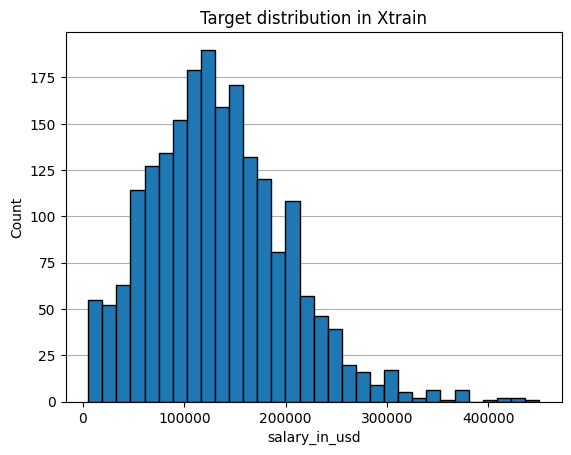

In [33]:
fig, ax = plt.subplots()

sns.histplot(ytrain, zorder=2, ax=ax, alpha=1)

plt.title('Target distribution in Xtrain')
plt.grid(True, axis='y', linestyle='-', zorder=1)

plt.show()

`Высокая ошибка, судя по всему, связана с аномальными значением зарплаты, преимущественно, для сеньеров (>300k $). Удалять такие данные не надо, поскольку такие зарплаты действительно могут существовать.`

In [34]:
Xtrain['experience_level'].value_counts()

,count
experience_level,
SE,1240
MI,536
EN,213
EX,78


`Интересно, что в датасете в принципе большинство позиций являются сеньерскими.`

`Средняя зарплата позиций с аномальными значениями зарплаты:`

In [35]:
df.loc[ytrain[ytrain > 300000].index].groupby('job_title')['salary_in_usd'].mean()

,salary_in_usd
job_title,
AI Scientist,423834.000000
Applied Data Scientist,380000.000000
Applied Machine Learning Scientist,423000.000000
Applied Scientist,329700.000000
Computer Vision Engineer,342810.000000
Data Analytics Lead,405000.000000
Data Architect,360840.000000
Data Engineer,313500.000000
Data Science Tech Lead,375000.000000


`Для улучшения модели можно добавить дополнительный признак-индикатор для высооплачиваемых вакансий.`

## **Задание 11 (0.5 балла)**

Придумайте признаки для улучшения качества модели на основе предыдущего пункта. Как вам кажется какими признаками можно улучшить качетсво модели? Реализуйте признаки и проверьте улучшилось ли качество модели.

**Примечание:**
Полный балл за задание ставится даже при отсутствии улучшения качества модели, важно попробовать проверить свои гипотезы и сделать выводы.

`Реализуем идею из предыдущего пункта.`

`Название вакансий с высокой зарплатой:`

In [36]:
high_salary_jobs = df.loc[ytrain[ytrain > 300000].index]['job_title'].unique()
high_salary_jobs

array(['Machine Learning Software Engineer', 'Applied Scientist',
       'Data Architect', 'Data Scientist', 'AI Scientist',
       'Data Engineer', 'Machine Learning Engineer', 'Head of Data',
       'Research Scientist', 'Applied Data Scientist',
       'Principal Data Scientist', 'Data Science Tech Lead',
       'Head of Data Science', 'Computer Vision Engineer',
       'Applied Machine Learning Scientist', 'Director of Data Science',
       'Data Analytics Lead'], dtype=object)

In [37]:
def high_salary_job(X):
    """
    Добавляет столбец high_salary_jobs, который равен 1, если job_title входит в список high_salary_jobs, иначе 0.
    """
    X_copy = X.copy()
    high_salary_jobs = ['Machine Learning Software Engineer', 'Applied Scientist',
       'Data Architect', 'Data Scientist', 'AI Scientist',
       'Data Engineer', 'Machine Learning Engineer', 'Head of Data',
       'Research Scientist', 'Applied Data Scientist',
       'Principal Data Scientist', 'Data Science Tech Lead',
       'Head of Data Science', 'Computer Vision Engineer',
       'Applied Machine Learning Scientist', 'Director of Data Science',
       'Data Analytics Lead']
    X_copy['high_salary_jobs'] = X_copy['job_title'].apply(lambda x: 1 if x in high_salary_jobs else 0)
    return X_copy

high_salary_transformer = FunctionTransformer(high_salary_job)

In [38]:
lgbm_nf_te = Pipeline([
    ('high_salary_transformer', high_salary_transformer),
    ('column_transformer', ct_te),
    ('model', LGBMRegressor(random_state=42))
])

lgbm_nf_te.fit(Xtrain, ytrain)

print_metrics(ytest, lgbm_nf_te.predict(Xtest))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42361
[LightGBM] [Info] Number of data points in the train set: 2067, number of used features: 6164
[LightGBM] [Info] Start training from score 133570.320271
MAPE: 0.388
RMSE: 51346.16983001252


`Качество немного улучшилось!`

## **Задание 12 (1 балл)**

Поупражняемся с разными бустингами!

- Используйте catboost.
- Обучите модель — на полном наборе данных с категориальными признаками.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


**Примечание:**
Замерять скорость = смотреть, как долго исполняется код.

In [39]:
Xtrain_new, Xval, ytrain_new, yval = train_test_split(high_salary_transformer.transform(Xtrain),
                                                      ytrain,
                                                      test_size=0.2,
                                                      random_state=42)

`Методика подбора параметров:` [ссылка](https://github.com/optuna/optuna-examples/blob/main/catboost/catboost_pruning.py)

`Сначала подберем оптимальное количество итераций.`

In [ ]:
model = CatBoostRegressor(
    cat_features=list(categorical),
    random_seed=42,
    iterations=2000,
    od_type='IncToDec',
    od_wait=50,
    od_pval=0.01,
    use_best_model=True,
    eval_metric='RMSE',
    logging_level='Verbose'
)

model.fit(
    Xtrain_new, ytrain_new,
    eval_set=[(Xval, yval)],
)

Learning rate set to 0.036102
0:	learn: 67093.1526956	test: 65132.7658064	best: 65132.7658064 (0)	total: 18ms	remaining: 36s
1:	learn: 66357.0734243	test: 64389.2421459	best: 64389.2421459 (1)	total: 32.7ms	remaining: 32.7s
2:	learn: 65757.8097421	test: 63714.5343092	best: 63714.5343092 (2)	total: 50.1ms	remaining: 33.4s
3:	learn: 65108.3091531	test: 63043.7794657	best: 63043.7794657 (3)	total: 61.8ms	remaining: 30.8s
4:	learn: 64443.1876182	test: 62380.1732751	best: 62380.1732751 (4)	total: 78.6ms	remaining: 31.3s
5:	learn: 63843.7161447	test: 61762.3440263	best: 61762.3440263 (5)	total: 101ms	remaining: 33.5s
6:	learn: 63311.5894254	test: 61236.0948667	best: 61236.0948667 (6)	total: 109ms	remaining: 31s
7:	learn: 62749.9445931	test: 60748.5878215	best: 60748.5878215 (7)	total: 128ms	remaining: 31.8s
8:	learn: 62390.4227269	test: 60436.3074265	best: 60436.3074265 (8)	total: 129ms	remaining: 28.6s
9:	learn: 61937.2050967	test: 60006.4318105	best: 60006.4318105 (9)	total: 135ms	remainin

In [ ]:
def objective(trial: optuna.Trial) -> float:
    param = {
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "eval_metric": "RMSE",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    gbm = CatBoostRegressor(**param,
                            cat_features=list(categorical),
                            random_seed=42,
                            iterations=309)

    pruning_callback = CatBoostPruningCallback(trial, "RMSE")
    gbm.fit(
        Xtrain_new,
        ytrain_new,
        eval_set=[(Xval, yval)],
        early_stopping_rounds=100,
        verbose=0,
        callbacks=[pruning_callback],
    )

    # evoke pruning manually.
    pruning_callback.check_pruned()

    preds = gbm.predict(Xval)
    rmse = RMSE(yval, preds)

    return rmse

study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="minimize"
)
study.optimize(objective, n_trials=1000, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-02-15 10:56:23,921] A new study created in memory with name: no-name-87dd9ece-206e-415b-a945-522ae9f3944a
[I 2025-02-15 10:56:24,343] Trial 0 finished with value: 52292.584344663526 and parameters: {'colsample_bylevel': 0.017194035771472892, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.707033443728681}. Best is trial 0 with value: 52292.584344663526.
[I 2025-02-15 10:56:25,081] Trial 1 finished with value: 50127.57881776734 and parameters: {'colsample_bylevel': 0.026175240409492453, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 50127.57881776734.
[I 2025-02-15 10:56:25,428] Trial 2 finished with value: 48897.355322212476 and parameters: {'colsample_bylevel': 0.0987819412595643, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.1305819691446226}. Best is trial 2 with value: 48897.355322212476.
[I 2025-02-15 10:56:25,827] Trial 3 finished with value: 5

Number of finished trials: 1000
Best trial:
  Value: 47915.27942103648
  Params: 
    colsample_bylevel: 0.09230497950141164
    depth: 8
    boosting_type: Plain
    bootstrap_type: MVS


In [ ]:
model = CatBoostRegressor(
    iterations=309,
    cat_features=list(categorical),
    random_seed=42,
    **trial.params,
    logging_level='Silent'
)
pipeline = Pipeline([
        ('high_salary_transformer', high_salary_transformer),
        ('model', model)
])

In [ ]:
%%time
pipeline.fit(Xtrain, ytrain)

CPU times: user 698 ms, sys: 72.4 ms, total: 770 ms
Wall time: 441 ms


Pipeline(steps=[('high_salary_transformer',
                 FunctionTransformer(func=<function high_salary_job at 0x7ed14f9c8220>)),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7ed12f401510>)])

In [ ]:
%%time
preds = pipeline.predict(Xtest)

CPU times: user 10.1 ms, sys: 8 µs, total: 10.1 ms
Wall time: 9.05 ms


In [ ]:
print_metrics(ytest, preds)

MAPE: 0.428
RMSE: 51004.639761764854


`Качество модели по метрике RMSE немного улучшилось, по MAPE немного ухудшилось. Обучается и предсказывает модель очень быстро.`

## **Задание 13 (1 балл)**

- Используйте xgboost.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.



In [40]:
Xtrain_te_new = ct_te.fit_transform(Xtrain_new, ytrain_new)
Xval_te = ct_te.transform(Xval)

`Методика подбора параметров:` [ссылка](https://www.kaggle.com/code/alisultanov/regression-xgboost-optuna)

In [41]:
def objective(trial):
    param = {
        'sampling_method': 'uniform',
        'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
        'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),
        'eta': trial.suggest_categorical('eta', [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'gamma': trial.suggest_categorical('gamma', [18, 19, 20, 21, 22, 23, 24, 25]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'colsample_bynode': trial.suggest_categorical('colsample_bynode', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'n_estimators': trial.suggest_int('n_estimators', 400, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 8, 600),
        'max_depth': trial.suggest_categorical('max_depth', [3, 4, 5, 6, 7]),
        'subsample': trial.suggest_categorical('subsample', [0.5,0.6,0.7,0.8,1.0]),
        'random_state': 42
    }

    model = XGBRegressor(**param, early_stopping_rounds=50)

    model.fit(
        Xtrain_te_new, ytrain_new,
        eval_set=[(Xval_te, yval)],
        verbose=False
    )

    preds = model.predict(Xval_te)

    rmse = RMSE(yval, preds)

    return rmse


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50,  timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-02-16 10:58:29,148] A new study created in memory with name: no-name-03789827-4a43-4288-b6b1-fedf97355768
[I 2025-02-16 10:59:40,339] Trial 0 finished with value: 54699.01953125 and parameters: {'lambda': 7.657046657978632, 'alpha': 16.719359090642065, 'eta': 0.5, 'gamma': 24, 'learning_rate': 0.01, 'colsample_bytree': 0.4, 'colsample_bynode': 0.3, 'n_estimators': 967, 'min_child_weight': 316, 'max_depth': 4, 'subsample': 0.6}. Best is trial 0 with value: 54699.01953125.
[I 2025-02-16 11:00:32,566] Trial 1 finished with value: 49214.38671875 and parameters: {'lambda': 14.2130738277423, 'alpha': 11.039199323109509, 'eta': 0.3, 'gamma': 23, 'learning_rate': 0.012, 'colsample_bytree': 0.7, 'colsample_bynode': 0.7, 'n_estimators': 862, 'min_child_weight': 68, 'max_depth': 7, 'subsample': 0.5}. Best is trial 1 with value: 49214.38671875.
[I 2025-02-16 11:01:46,255] Trial 2 finished with value: 49894.43359375 and parameters: {'lambda': 12.461459840921933, 'alpha': 8.189787070500852, 

Number of finished trials: 14
Best trial:
  Value: 48719.83984375
  Params: 
    lambda: 16.490734769224886
    alpha: 9.941275174973574
    eta: 0.3
    gamma: 23
    learning_rate: 0.018
    colsample_bytree: 0.5
    colsample_bynode: 0.4
    n_estimators: 834
    min_child_weight: 21
    max_depth: 7
    subsample: 0.5


In [43]:
model = XGBRegressor(**trial.params, random_state=42)

pipeline = Pipeline([
    ('high_salary_transformer', high_salary_transformer),
    ('column_transformer', ct_te),
    ('model', model)
])

In [44]:
%%time
pipeline.fit(Xtrain, ytrain)

CPU times: user 2min 35s, sys: 1.41 s, total: 2min 37s
Wall time: 1min 46s


Pipeline(steps=[('high_salary_transformer',
                 FunctionTransformer(func=<function high_salary_job at 0x7f95ae55b740>)),
                ('column_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('target_encoder',
                                                  TargetEncoder(random_state=42),
                                                  Index(['experience_level', 'employment_type', 'job_title', 'salary_currency',
       'employee_residence', 'company_locatio...
                              eval_metric=None, feature_types=None, gamma=23,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              lambda=16.490734769224886, learning_rate=0.018,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None, min_child_weight=21,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=834, ...))])

In [45]:
%%time
preds = pipeline.predict(Xtest)

CPU times: user 201 ms, sys: 8.97 ms, total: 210 ms
Wall time: 161 ms


In [46]:
print_metrics(ytest, preds)

MAPE: 0.348
RMSE: 52628.015625


`Модель очень медленно обучается и медленно применяется по сравнению с catboost. Качество по метрике MAPE немного улучшилось, а по RMSE ухудшилось, по сравнению с результатами задания 11.`

## **Задание 14 (1 балл)**

- Используйте lgbm.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


In [49]:
def objective(trial):
    param = {
        'metric': 'rmse',
        'random_state': 42,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves': trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth': trial.suggest_int('min_data_per_groups', 1, 100),
    }
    model = LGBMRegressor(**param, early_stopping_rounds=100, verbose=-1)

    model.fit(Xtrain_te_new,
              ytrain_new,
              eval_set=[(Xval_te, yval)])

    preds = model.predict(Xval_te)

    rmse = RMSE(yval, preds)

    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=600)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2025-02-16 11:29:11,080] A new study created in memory with name: no-name-4efd3743-30e7-4d73-8920-48456f7010b8
[I 2025-02-16 11:29:38,567] Trial 0 finished with value: 49235.88969508353 and parameters: {'reg_alpha': 0.5933315918314382, 'reg_lambda': 0.019353367105390876, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 100, 'num_leaves': 55, 'min_child_samples': 140, 'min_data_per_groups': 29}. Best is trial 0 with value: 49235.88969508353.
[I 2025-02-16 11:30:25,699] Trial 1 finished with value: 49584.27915830167 and parameters: {'reg_alpha': 0.04403969836473971, 'reg_lambda': 0.3353876304626211, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 734, 'min_child_samples': 239, 'min_data_per_groups': 89}. Best is trial 0 with value: 49235.88969508353.
[I 2025-02-16 11:30:39,653] Trial 2 finished with value: 48363.22879199624 and parameters: {'reg_alpha': 0.14914238693891307, 'reg_lambda': 2.12995278200934

Number of finished trials: 15
Best trial: {'reg_alpha': 0.006990359364635428, 'reg_lambda': 0.012282759237505065, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 963, 'min_child_samples': 5, 'min_data_per_groups': 58}


In [54]:
model = LGBMRegressor(**trial.params, random_state=42)

pipeline = Pipeline([
    ('high_salary_transformer', high_salary_transformer),
    ('column_transformer', ct_te),
    ('model', model)
])

In [55]:
%%time
pipeline.fit(Xtrain, ytrain)

CPU times: user 1min 30s, sys: 166 ms, total: 1min 30s
Wall time: 1min 31s


Pipeline(steps=[('high_salary_transformer',
                 FunctionTransformer(func=<function high_salary_job at 0x7f95ae55b740>)),
                ('column_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('target_encoder',
                                                  TargetEncoder(random_state=42),
                                                  Index(['experience_level', 'employment_type', 'job_title', 'salary_currency',
       'employee_residence', 'company_location', 'company_size'],
      dtype='object'))])),
                ('model',
                 LGBMRegressor(alpha=9.941275174973574, colsample_bynode=0.4,
                               colsample_bytree=0.5, eta=0.3, gamma=23,
                               lambda=16.490734769224886, learning_rate=0.018,
                               max_depth=7, min_child_weight=21,
                               n_estimators=834, random_state=42,
                               subsample=0.5))])

In [56]:
%%time
preds = pipeline.predict(Xtest)

CPU times: user 140 ms, sys: 1.01 ms, total: 141 ms
Wall time: 140 ms


In [57]:
print_metrics(ytest, preds)

MAPE: 0.394
RMSE: 51324.24685010366


`Модель обучается быстрее XGBoost, но медленние чем catboost. Время применении модели сопоставимо со временем применения XGBoost. Качество модели практически не изменилось по сравнению с моделью из задания 11.`

## **Задание 15 (0.4 балла)**

Сделайте выводы про модели и решение задачи.

- Какая из моделей показала лучший результат по качеству?
- Какая из моделей показала лучший результат по качеству, скорости обучения и скорости предсказания в совокупности?
- Насколько бустинги превзошли линейную модель? Целесообразно ли их использование?

|Model \ Metric|MAPE|RMSE |
|--------------|----|-----|
|catboost|0.43|51005|
|Target-enc XGBoost|0.35|52628|
|Target-enc + LGBM|0.39|51324|
|Ohe + lin-reg|0.47|53324|

`Наилучшее качество по метрике MAPE показала модель XGBoost. По метрике RMSE -- catboost. В совокупности по качеству, скорости обучения и скорости предсказания наилучший результат показала модель catboost.`

`Стоит отметить, что низкая скорость обучения и применения моделей XGBoost и LGBM связана в том числе с долгим применением кодировки TargetEncoder.`

`В целом бустинги не сильно превзошли линейную модель по качеству, поэтому если задача требует выявления важных признаков, можно использовать вместо бустингов модель линейной регрессии с небольшой потерей в точности прогнозов.`

# **Часть 2: кластеризация типов движений**
**Количество баллов:** 3

В этой части будем работать с набором данных Samsung Human Activity Recognition. Набор данных заранее предобработан и снова доступен вам по [ссылке](https://drive.google.com/file/d/16ISu7lMumt5rbticbOggHMRjwTGBETtO/view?usp=sharing).

### **Постановка задачи**
Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S2. Вид активности человека с телефоном в кармане известен:
- 1 - ходьба,
- 2 - подъем вверх по лестнице,
- 3 - спуск по лестнице,
- 4 - сидение,
- 5 - стояние,
- 6 - лежание


Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков.

In [60]:
plt.style.use(['seaborn-v0_8-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

%matplotlib inline
%config InlineBackend.figure_format="retina"

RANDOM_STATE = 42

### **Задание 16 (0.1 балл)**
Прочитайте данные из файлов и объедните тестовую и обучающие выборки.

В файлах ```..._labels``` лежат настоящие классы. Их также объедините, но в отдельную переменную (например ```y```). Данный вектор для кластеризации нам не нужен, но мы будем смотреть по нему метрики.

In [66]:
train = pd.read_csv('samsung_train.txt', delim_whitespace=True, header=None)
test = pd.read_csv('samsung_test.txt', delim_whitespace=True, header=None)

train_labels = pd.read_csv('samsung_train_labels.txt', delim_whitespace=True, header=None)
test_labels = pd.read_csv('samsung_test_labels.txt', delim_whitespace=True, header=None)

In [84]:
# Ваш код здесь
X = pd.concat([train, test], axis=0).reset_index(drop=True)
y = pd.concat([train_labels, test_labels], axis=0).reset_index()[0]

In [73]:
# убедимся, что y содержит нужные нам классы
np.unique(y)

array([1, 2, 3, 4, 5, 6])

### **Задание 17 (0.2 балла)**

Так как мы будем пользоваться метрическими алгоритмами, отмасштабируйте выборку с помощью ```StandardScaler```.

In [86]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### **Задание 18 (0.5 балла)**

Данных много и размерность большая. Чтобы ускорить рещение задачи с точки зрения построения модели, мы используем методы **понижения размерности**.

- Понизьте размерность с помощью `PCA`, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии отмасштабированных данных. Вам пригодится [документация](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

**Примечание:**
Для этого сумма значений массива pca.explained_variance_ratio_ должна быть не меньше 0.9.  ```random_state``` используйте из объявленной в самом начале переменной ```RANDOM_STATE``` (42).

In [112]:
pca = None

for i in range(1, X_scaled.shape[1] + 1):
    pca = PCA(n_components=i)
    pca.fit(X_scaled)
    if sum(pca.explained_variance_ratio_) >= 0.9:
        print(f'{i} components')
        break

X_pca = pca.transform(X_scaled)

65 components


In [181]:
X

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10294,0.310155,-0.053391,-0.099109,-0.287866,-0.140589,-0.215088,-0.356083,-0.148775,-0.232057,0.185361,...,0.074472,-0.376278,-0.750809,-0.337422,0.346295,0.884904,-0.698885,-0.651732,0.274627,0.184784
10295,0.363385,-0.039214,-0.105915,-0.305388,0.028148,-0.196373,-0.373540,-0.030036,-0.270237,0.185361,...,0.101859,-0.320418,-0.700274,-0.736701,-0.372889,-0.657421,0.322549,-0.655181,0.273578,0.182412
10296,0.349966,0.030077,-0.115788,-0.329638,-0.042143,-0.250181,-0.388017,-0.133257,-0.347029,0.007471,...,-0.066249,-0.118854,-0.467179,-0.181560,0.088574,0.696663,0.363139,-0.655357,0.274479,0.181184
10297,0.237594,0.018467,-0.096499,-0.323114,-0.229775,-0.207574,-0.392380,-0.279610,-0.289477,0.007471,...,-0.046467,-0.205445,-0.617737,0.444558,-0.819188,0.929294,-0.008398,-0.659719,0.264782,0.187563


### **Задание 19 (0.2 балла)**

Визуализируйте данные в проекции на первые две главные компоненты. Используйте ```cmap="virdis"``` или любой другой, с которым будет красиво!

Можете раскрасить кластеры.

In [147]:
def pca_viz(labels):
    """
    Строит график данных в проекции на две главные компоненты.
    """
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
    plt.title("Сlusters Visualization with the First Two Principal Components of PCA")
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

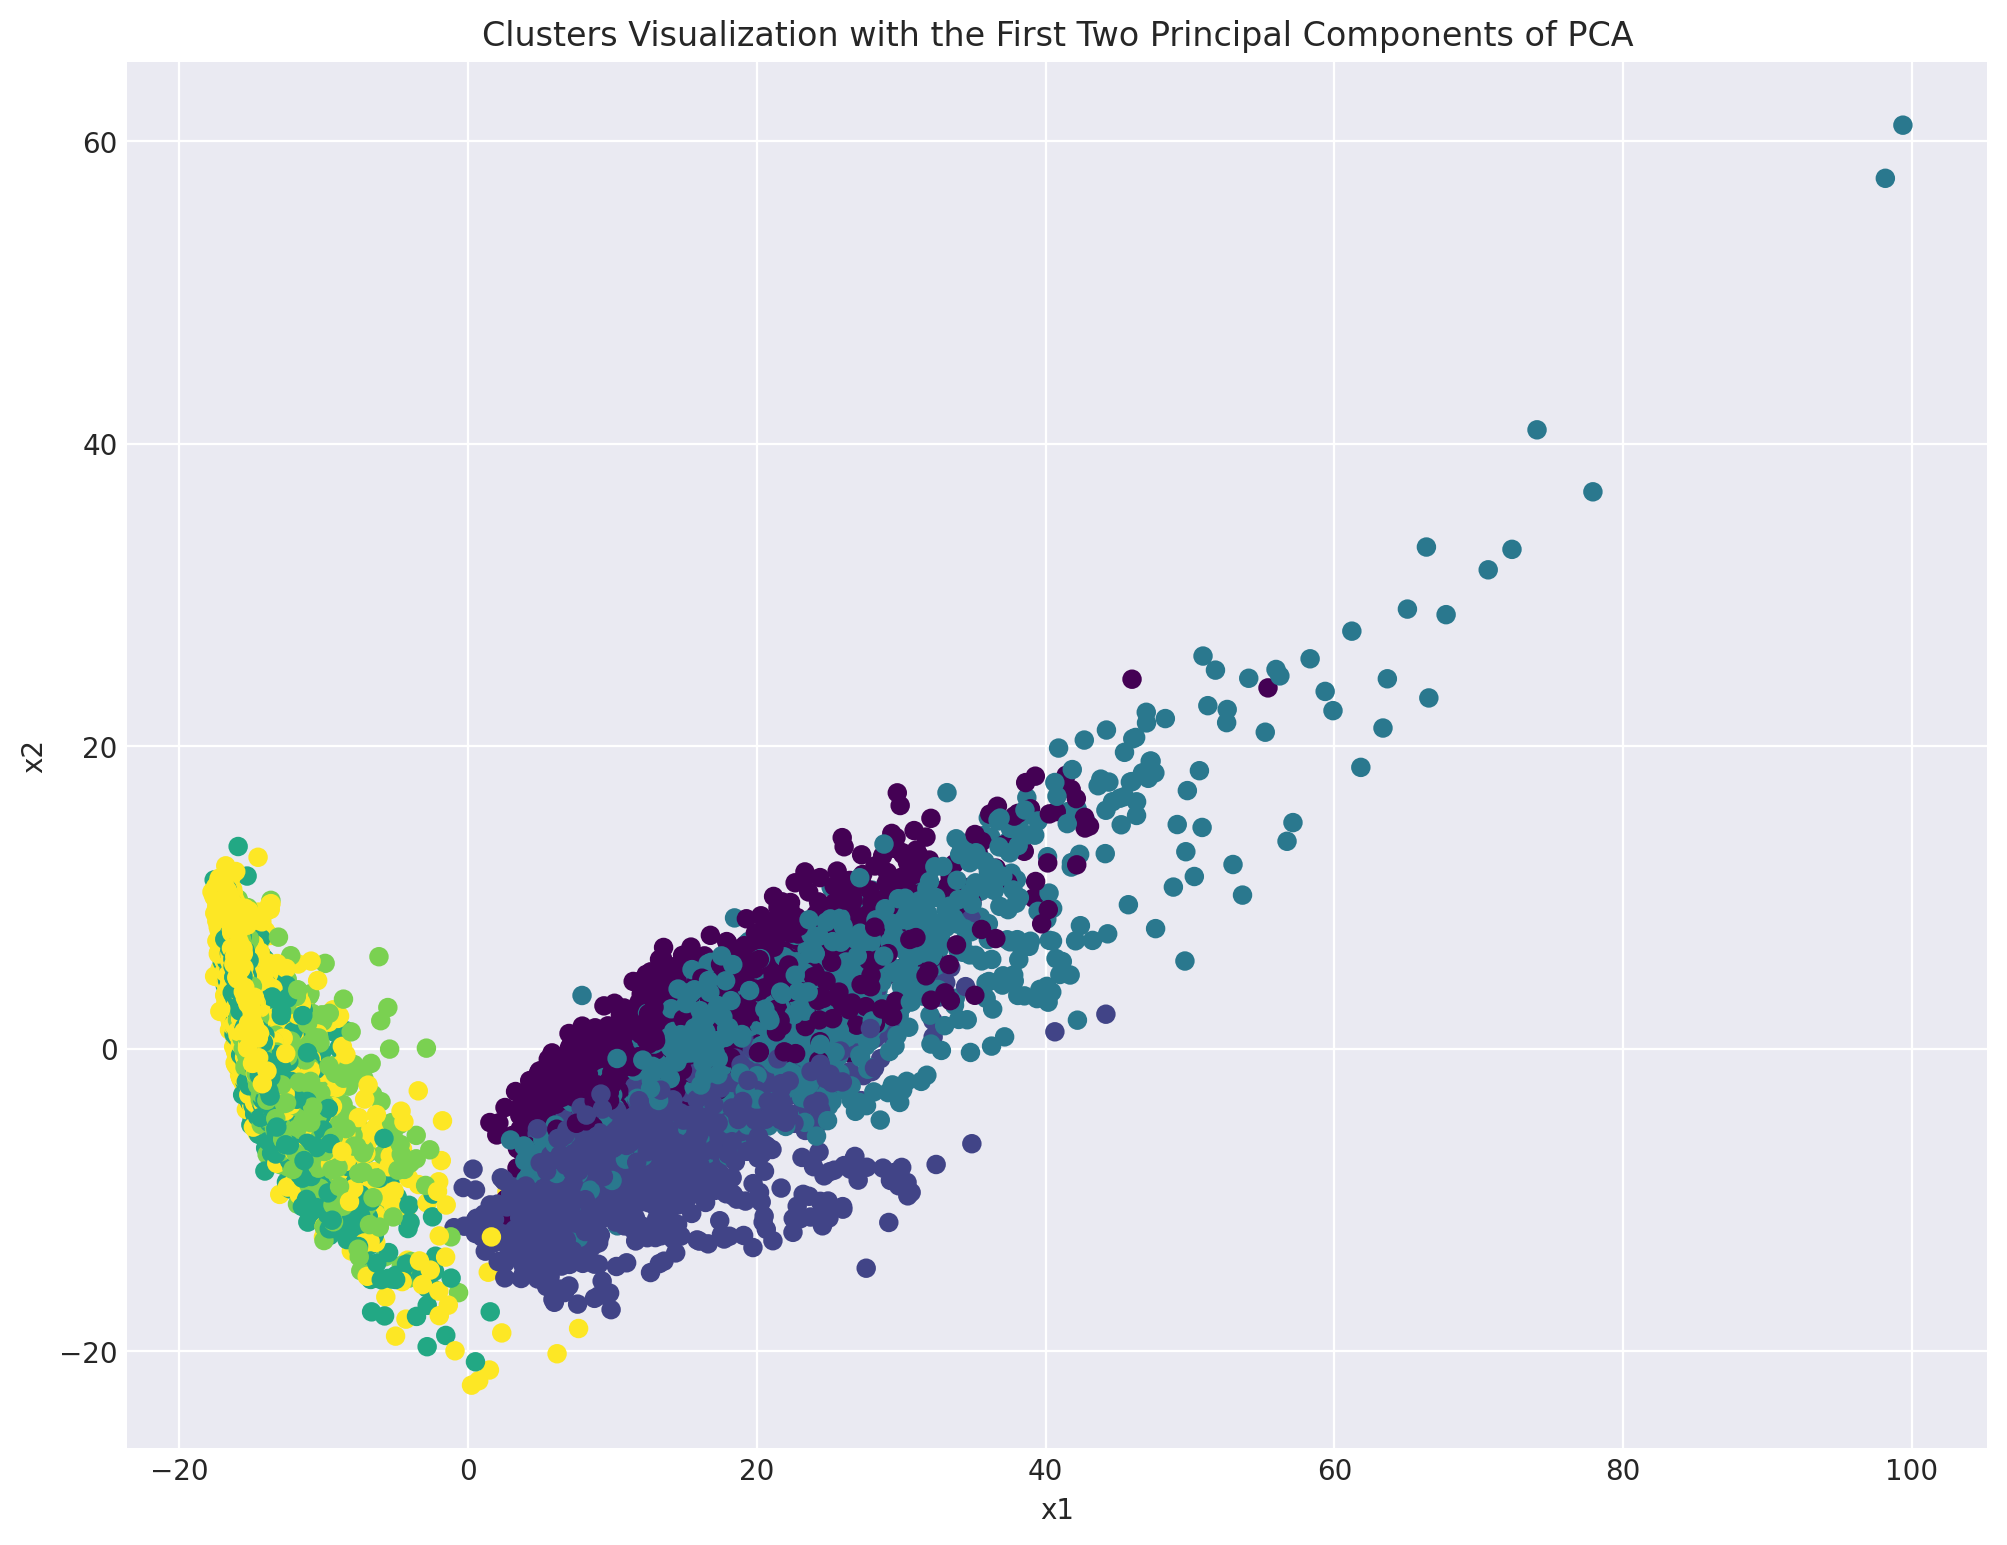

In [148]:
pca_viz(y)

### **Задание 19. (0.5 балла)**

Разберёмся с `KMeans`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

- Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет `PCA` размерностью. Нужно искать 6 кластеров (изначально у нас 6 классов). Засеките время обучения и время инференса.

**Параметры обучения:**

```n_clusters = 6``` (число уникальных меток целевого класса = 6)

```n_init = 100```

```random_state = RANDOM_STATE``` (для воспроизводимости результата, не забывайте указывать его и дальше!)

In [150]:
kmeans = KMeans(n_clusters=6,
                n_init=100,
                random_state=42)

In [151]:
%%time
kmeans.fit(X_pca)

CPU times: user 11.4 s, sys: 7.6 s, total: 19 s
Wall time: 10.5 s


KMeans(n_clusters=6, n_init=100, random_state=42)

In [152]:
%%time
labels = kmeans.predict(X_pca)

CPU times: user 4.62 ms, sys: 4.02 ms, total: 8.65 ms
Wall time: 4.34 ms


In [153]:
labels

array([2, 2, 2, ..., 3, 3, 3], dtype=int32)

### **Задание 20 (0.2 балла)**

- Визуализируйте данные в проекции на первые две главные компоненты.
- Раскрасьте точки в соответствии с полученными метками кластеров.

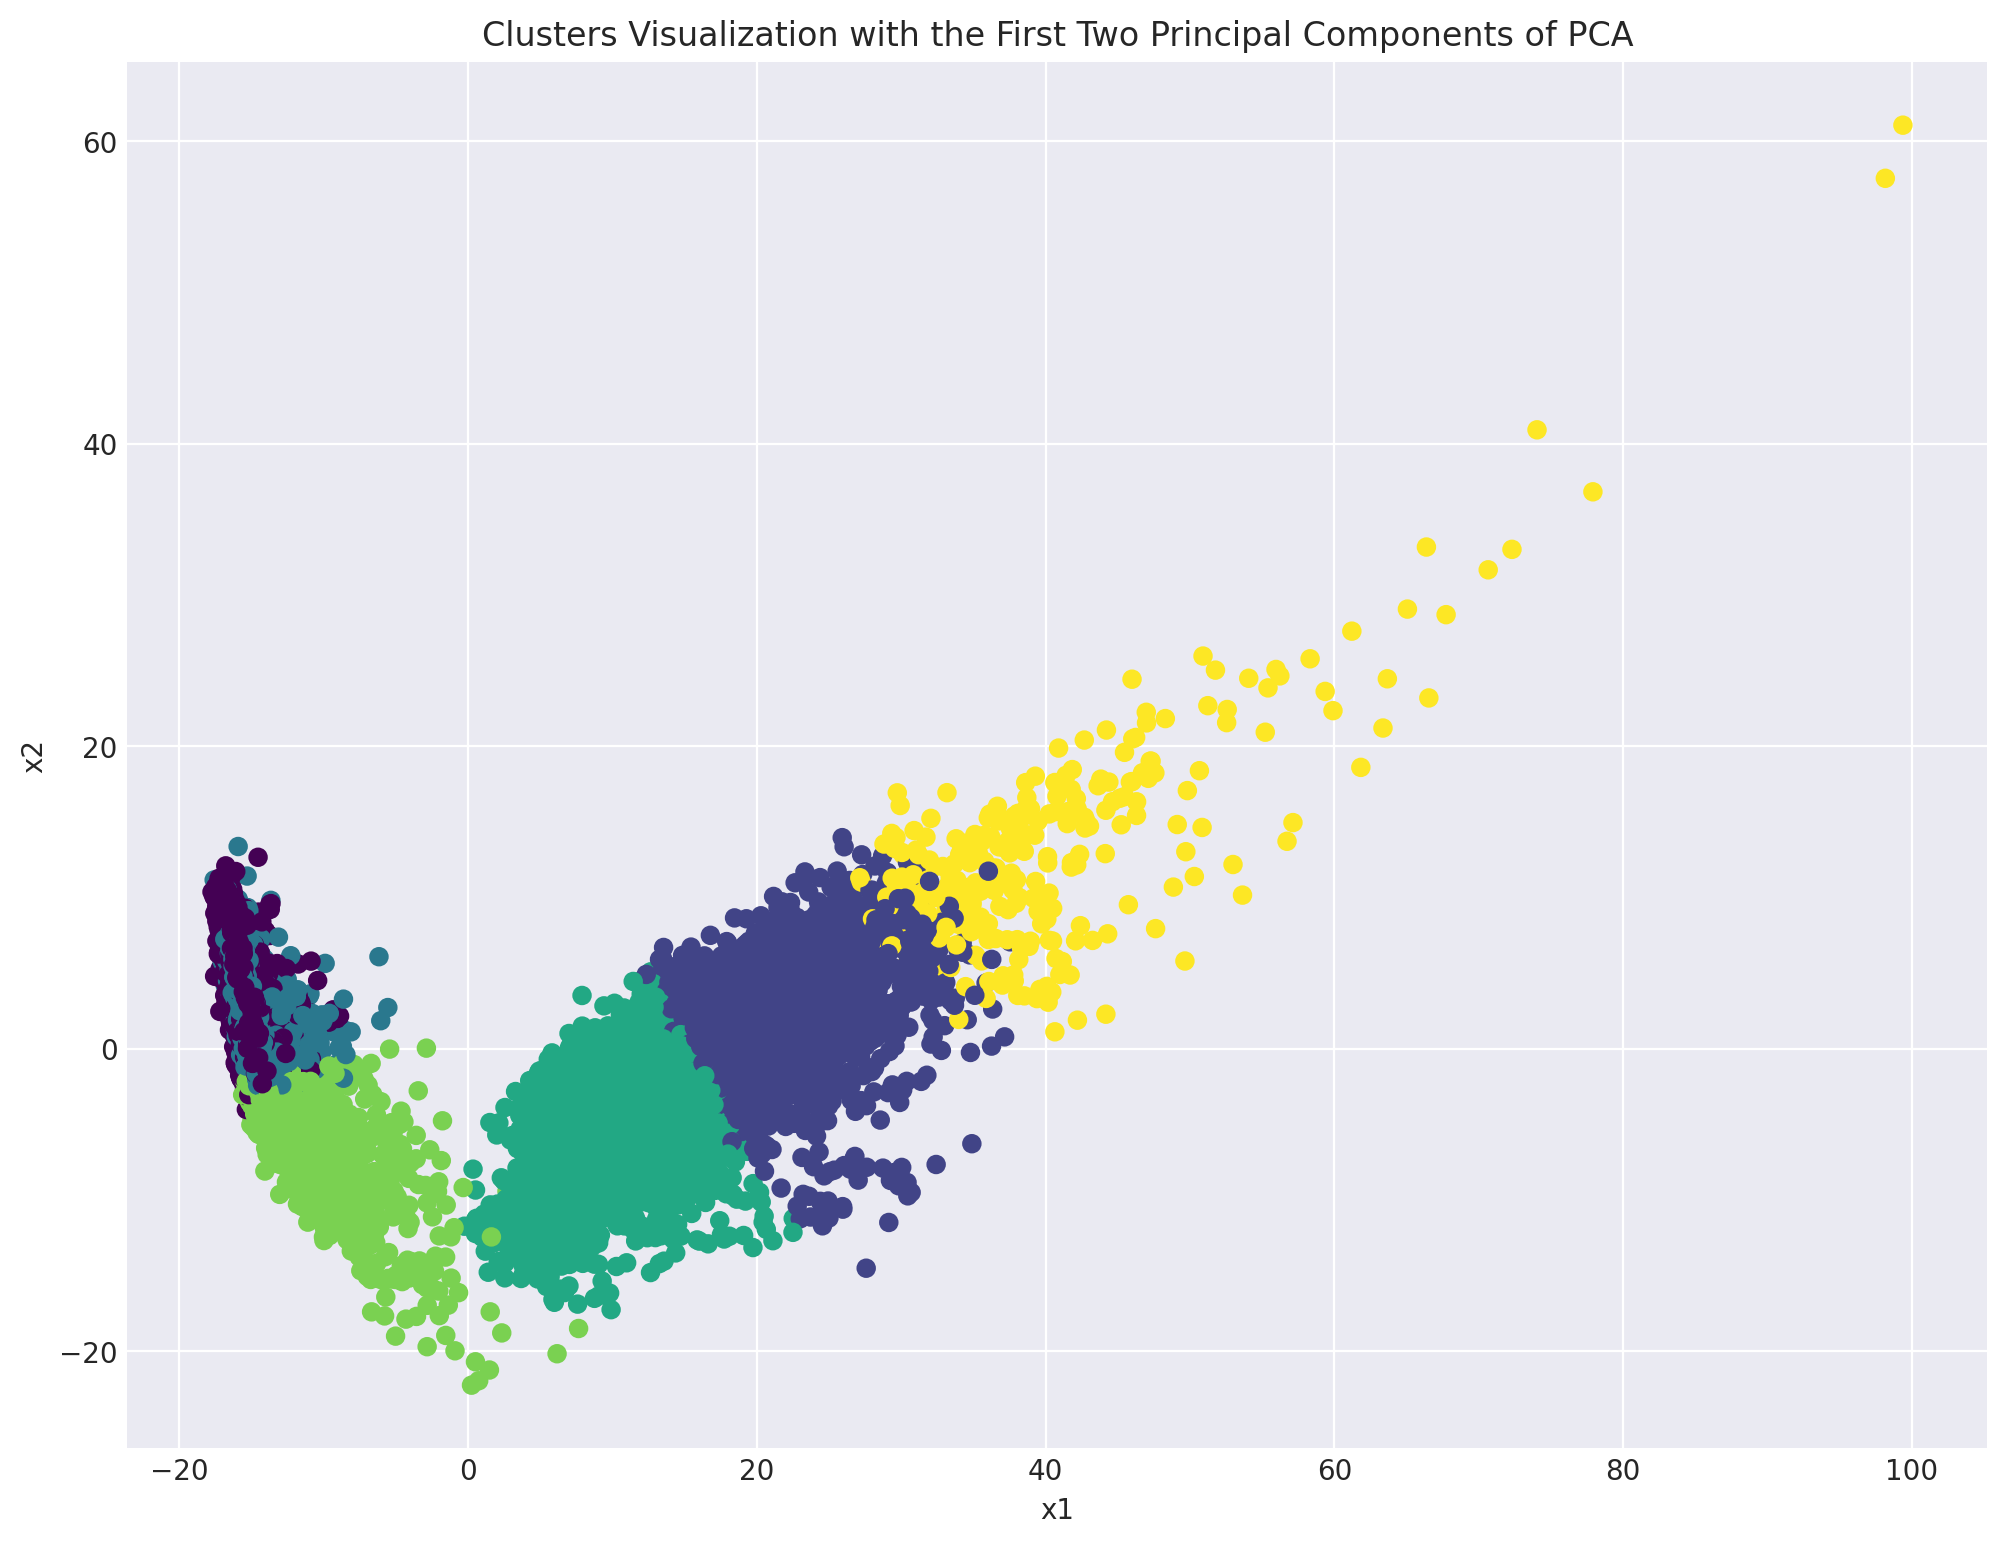

In [154]:
pca_viz(labels)

### **Задание 21 (0.3 балла)**

- Выберите какие-то метрики (минимум две) из известных вам. Объясните свой выбор
- Выведите на экран значения метрик качества, сделайте вывод о них и используйте их далее.

`Поскольку правильные метки классов нам известны, и при этом в датасете много объектов и мало меток, можно воспользоваться любой внешней метрикой.`

`Будем считать гомогенность, полноту, а также V - меру, для оценки обоих показателей.`

In [138]:
def print_cluster_metrics(labels_true, labels_pred):
    """
    Печатает метрики кластеризации.
    """
    print(f'Гомогенность: {homogeneity_score(labels_true, labels_pred)}')
    print(f'Полнота: {completeness_score(labels_true, labels_pred)}')
    print(f'V-мера: {v_measure_score(labels_true, labels_pred)}')

In [139]:
print_cluster_metrics(y, labels)

Гомогенность: 0.5405702796626982
Полнота: 0.5809669531868589
V-мера: 0.5600410921019029


`Качество довольно плохое: кластеры достаточно неоднородные, исходные классы плохо покрываюстся предсказанными.`

### **Задание 22 (0.7 баллов)**

Теперь попробуем сделать кластеризацию с помощью `AgglomerativeClustering`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

- Засеките время обучения и время инференса. После кластеризации также:
  - Вновь визуализируйте данные с раскраской по полученным меткам
  - Выведите метрики. Засеките время обучения и время инференса. Сравните с ```KMeans```.

Ответьте на следующие вопросы:
* Стало ли лучше?
* Почему?

23.5 s ± 3.94 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


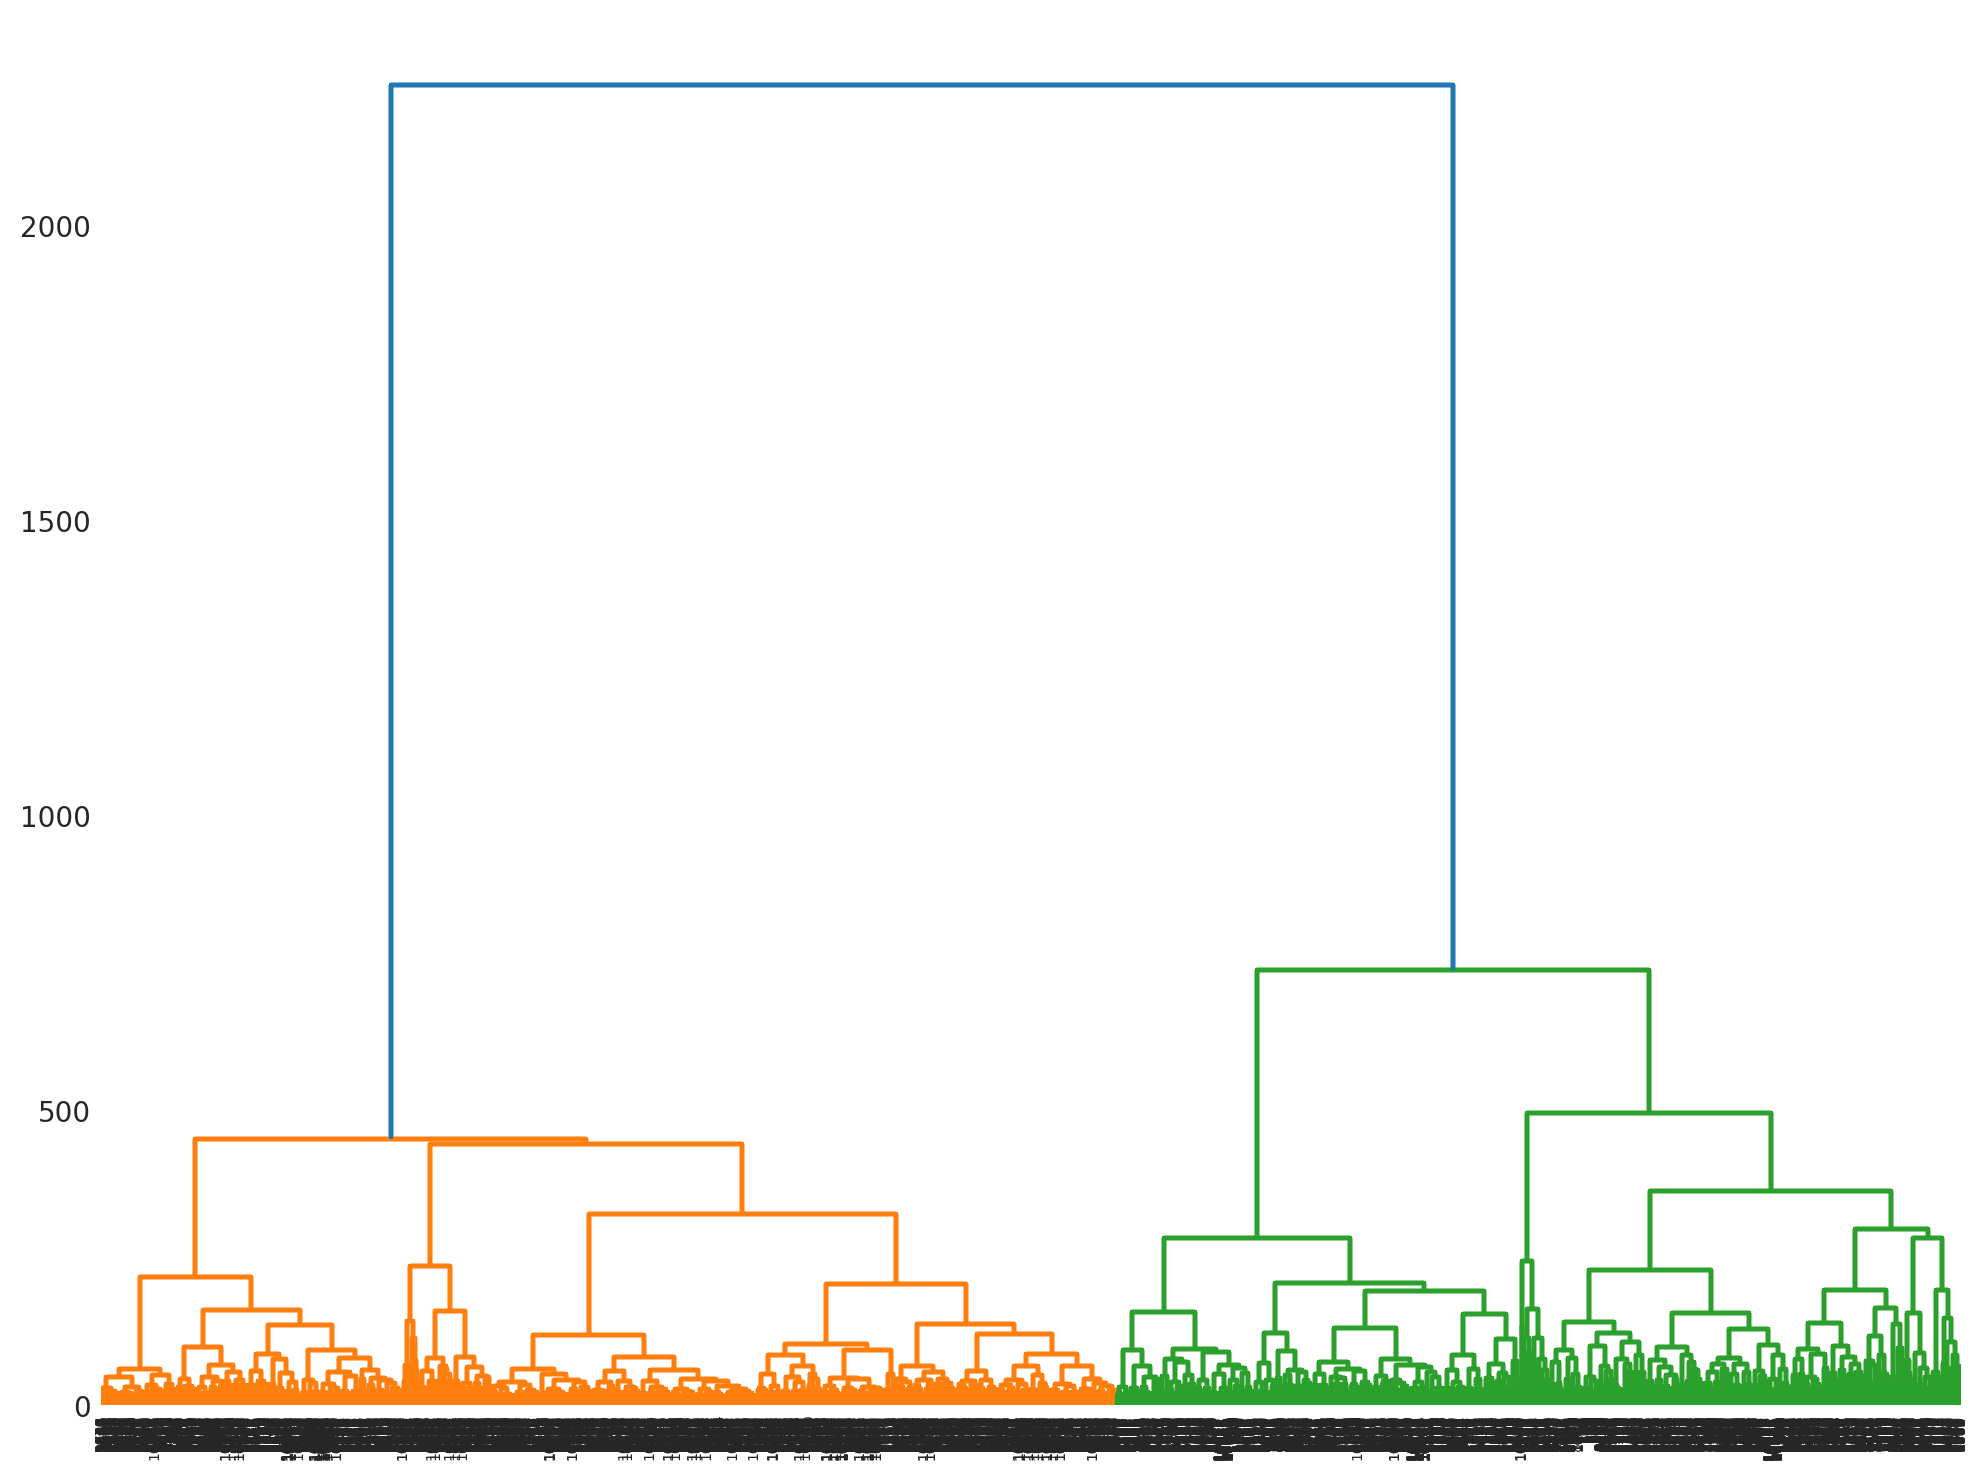

In [187]:
%%timeit
Dendrogram = shc.dendrogram((shc.linkage(X_pca, method ='ward')))

agg = AgglomerativeClustering(n_clusters=6)

agg = agg.fit(X_pca)

In [177]:
%%time
labels = agg.labels_

CPU times: user 17 µs, sys: 1e+03 ns, total: 18 µs
Wall time: 20.7 µs


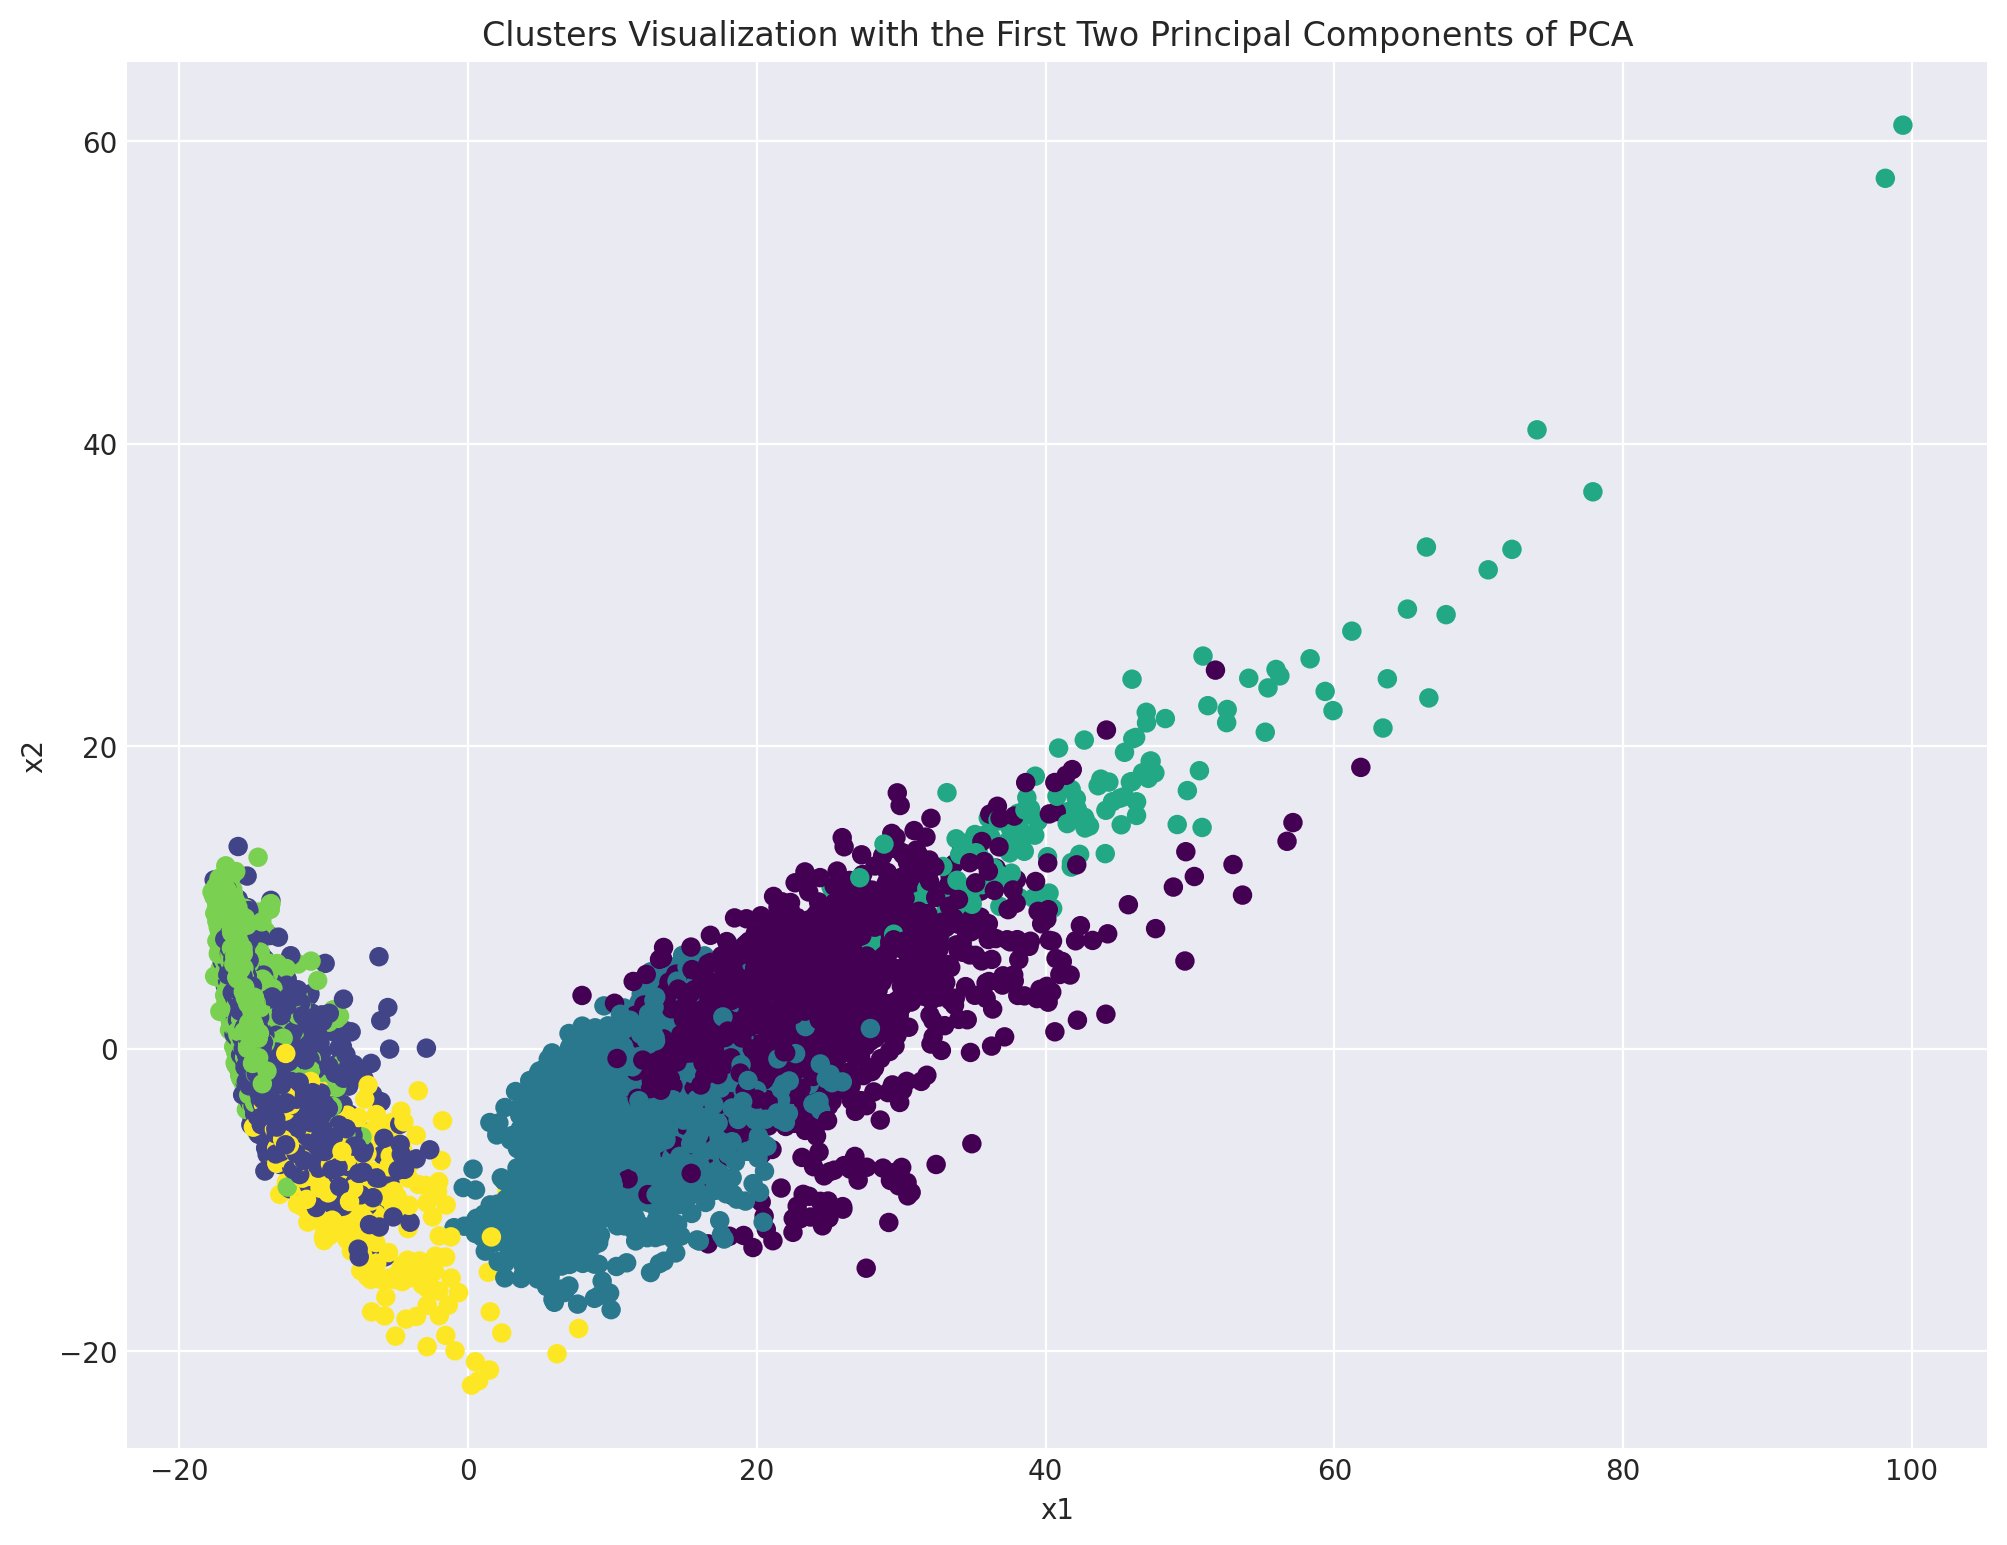

In [179]:
pca_viz(labels)

In [180]:
print_cluster_metrics(y, labels)

Гомогенность: 0.5779071626156045
Полнота: 0.6728743591901729
V-мера: 0.6217855076000528


`Результат получился сильно выше по полноте и немного выше по гомогенности чем при разбиении Kmeans. Скорее всего это связано с тем, что поверхность разбиения у кластеров сложной формы, которую как раз таки может уловить иерархическая кластеризация в отличие от Kmeans (Kmeans не справляется с определением кластеров со сложной геометрией).`

`У Kmeans есть свой плюс -- этот алгоритм очень быстро обучается и применяется по сравнению с иерархической кластеризацией.`

**Ваш вывод здесь**

### **Задание 23 (0.3 балла)**
Для самой успешной из полученных кластеризаций попробуйте дать интерпретацию кластеров. Опишите характеристики объектов, попавших в каждый кластер. Для этого можете ответить на следующие вопросы:

* Похожи ли объекты внутри каждого кластера на определенный тип активности человека?
* В каких кластерах смешано несколько типов активности? С чем, на ваш взгляд, это может быть связано?
* Качественная ли получилась кластеризация? На основании чего вы можете сделать такой вывод?

`При визуалилизации двух главных компонент видны два больших кластера, включающих в себя по три других накладывающихся друг на друга кластера. Это можно объяснить с той точки зрения, что виды активности можно условно разделить на две группы: статические (сидение, стояние, лежание) и динамические (ходьба, спуск по лестнице, подъем по лестнице).`

`Левая группа кластеров скорее всего относится к статическим нагрузкам, поскольку для акселерометра и гироскопа эти виды активности должны быть очень похожи друг на друга, т.к. человек практически не двигается. Разброс данных скорее всего тоже должен быть небольшим.`

`Правая группа кластеров по этой логике должна относиться к динамическим нагрузкам. Кластеры визуально более четко разделяются и имееют большой разброс данных, поскольку при высокой активности виды движения гораздо легче определить.`

`Обе группы кластеров имееют общую границу, это можно объяснить тем, что положение телефона при низкой активности человека может совпадать с положением телефона при статическом виде нагрузки.`

`Кластеризация с помощью иерархической кластеризации получилось неплохой, поскольку видно, что у кластеров внутри группы нет четкой границы, как в случае Kmeans. При этом у каждого кластера должна быть общая граница с любым из других 6 кластеров. При кластеризации с помощью иерархической кластеризации общая граница есть не у всех кластеров.`

`В целом, качество кластеризации по V-мере достаточно неплохо соотвествует вышеописанной логике.`

## **Бонус-задание (1 балл)**
![RedPanda](http://imgur.com/6Aa52Lm.png)

Алгоритмы кластеризации могут применяться в самых разных задачах. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации. В бонусе предлагаем вам попрактиковаться именно в этом на чудесной утке и совах (```duck.jpg``` и ```owls.jpg```)

### **(0.1 балл)**

- Откройте изображения, после чего визуализируйте их с помощью ```plt.imshow()```

In [ ]:
from PIL import Image
# or
#import cv2

### **(0.4 балла)**

Для каждого изображения, используя кластеризацию ```KMeans```, выделите компоненты, охарактеризовав каждый пиксель следующим образом: $$\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$$
 где
- $x_i$ и $y_i$ — координаты пикселя,
- $r_i, g_i, b_i$ — его цвет,
- $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

Примените полученную функцию, взяв следующие $\lambda$: 0.3 и 1.5 для ```duck.jpg``` и ```owls.jpg``` (или другие, но тогда с вас красивые результаты :) )

**Примечание:**
Число кластеров подберите разумным образом на свой вкус (в качестве нулевого приближения можно взять 3)

In [ ]:
def find_components(image, lmbd, n_clusters):
    #your code here

### **(0.4 балла)**

Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html).


**Примечание:**

Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения в 2 раза.

**Подсказка:**```skimage``` с его ```color``` и ```transform``` в этом помогут :)

Или же воспользуйтесь аналогичными средствами ```PIL``` или ```cv2```

In [ ]:
def spectral_segmentation(image, n_clusters, beta, eps):
    #your code here

### **(0.1 балл)**
Визуализируйте результаты сегментации (аналогично рисунку в начале задания 2) для обоих методов.

**Спасибо! Вы — человек — большой трудяга!**

Успокоительный котобонус :)

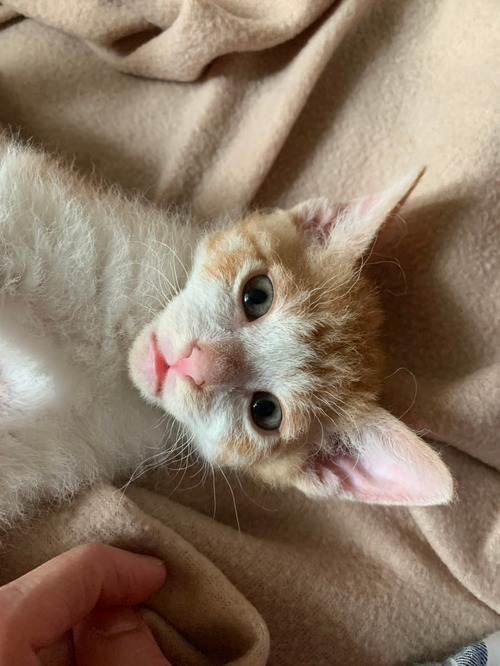